# TPT pipeline with ERA5

In [2]:
import sys
sys.path.append("../..")

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import netCDF4 as nc
import feature_template
import feature_stratosphere
from importlib import reload
import sys 
import os
from os import mkdir, makedirs
from os.path import join,exists
from importlib import reload
import pickle
import tpt_utils
from sklearn.cluster import KMeans, MiniBatchKMeans
from datetime import datetime
from calendar import monthrange
import cartopy
from cartopy import crs as ccrs

In [4]:
import matplotlib
matplotlib.rcParams["font.size"] = 18
%matplotlib inline

# Define some utility functions

In [160]:
def display_pole_field(field,lat,lon,u=None,v=None,vmin=None,vmax=None,fig=None,ax=None):
    # field, u, and v must have shape (lat, lon)
    data_crs = ccrs.PlateCarree() 
    ax_crs = ccrs.Orthographic(-10,90)
    if fig is None or ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1,projection=ax_crs)
    im = ax.pcolormesh(lon,lat,field,shading='nearest',cmap='coolwarm',transform=data_crs,vmin=vmin,vmax=vmax)
    # If there's a vector field, overlay that 
    if u is not None and v is not None:
        lon_subset = np.arange(0,lon.size,3) #np.linspace(0,lon.size-1,24).astype(int)
        lat_subset = np.arange(2,lat.size-1,3) #np.linspace(1,lat.size-2,60).astype(int)
        ax.quiver(
            lon[lon_subset],lat[lat_subset],
            u[lat_subset,:][:,lon_subset],
            v[lat_subset,:][:,lon_subset],
            transform=data_crs,color='black',zorder=5,
        )
    ax.add_feature(cartopy.feature.COASTLINE, zorder=3, edgecolor='black')
    fig.colorbar(im,ax=ax)
    return fig,ax,data_crs

# Set up experiment

In [205]:
create_eofs_flag =                   1
featurize_flag =                     1

In [197]:
topic_dir = "/scratch/jf4241/ecmwf_data/"
filedict = dict({
    "data": dict({
        "ra": dict({
            "traj": dict({
                "dir": join(topic_dir, "era5_data", "raw_data", "2022-08-14"), # Directory with possibly many files
            }),
            "stats": dict({
                "dir": join(topic_dir, "era5_data", "stats", "2022-08-17"),
                "eof_filename": "eofs.nc",
                "monthly_climatology_filename": "monclim.nc",
            }),
            "feat_all": dict({
                "dir": join(topic_dir, "era5_data", "features_all", "2022-08-15"),
                "filename": "era5_features_all.nc",
            }),
            "feat_tpt": dict({
                "dir": join(topic_dir, "era5_data", "features_tpt", "2022-08-15",),
                "filename": "era5_features_tpt.nc",
            }),
        }),
        # TODO: add another directory for S2S hindcasts
    }),
    "results": dict({
        "dir": join(topic_dir, "results", "tpt_quantities", "2022-08-15")
    })
})

In [182]:
# Create the directories if they don't exist already
for src in list(filedict["data"].keys()):
    for data_stage in ["traj","stats","feat_all","feat_tpt"]:
        path = filedict["data"][src][data_stage]["dir"]
        if not exists(path):
            makedirs(path, exist_ok=True)
path = filedict["results"]["dir"]
if not exists(path): makedirs(path, exist_ok=True)

In [183]:
file_list = [f for f in os.listdir(filedict["data"]["ra"]["traj"]["dir"]) if f.endswith(".nc")]
year_list = np.arange(1959,2019)

# Define any features that need defining, such as EOFs as linear coordinates

Assemble monthly anomalies

In [80]:
# Compute some EOFs of monthly mean data 
trajdir = filedict["data"]["ra"]["traj"]["dir"]
file_list = [join(trajdir, f) for f in os.listdir(trajdir)]
z_list = []
for f in file_list:
    zmean = xr.open_dataset(f)['z'].resample(time="1M").mean()
    z_list += [zmean] # Using the fact that each file is a whole month

In [106]:
zm = xr.concat(z_list, dim="time").sortby("time")
zm_climatology = zm.groupby("time.month").mean(dim="time")
zma = zm.groupby("time.month") - zm_climatology # Anomaly

Assemble a data matrix. Restrict to EOFs north of 20 degrees N

In [147]:
zm_20N_w = zma.where(
    (zma.latitude >= 20) *
    zma.month.isin([10, 11, 12, 1, 2, 3]),
    drop=True
) 
zm_20N_w *= np.sqrt(np.maximum(0, np.cos(zm_20N_w.latitude*np.pi/180)))
X = zm_20N_w.transpose("level","time","latitude","longitude").to_numpy().reshape((
    zm_20N_w.level.size, zm_20N_w.time.size, zm_20N_w.latitude.size*zm_20N_w.longitude.size, 
))

In [186]:
num_modes = 10
eofs = xr.DataArray(
    coords = {
        "level": zm_20N_w.level, 
        "latitude": zm_20N_w.latitude, 
        "longitude": zm_20N_w.longitude, 
        "mode": 1 + np.arange(num_modes)},
    dims = ["level", "latitude", "longitude", "mode"],
)
variance_fraction = xr.DataArray(
    coords = {"level": zm_20N_w.level, "mode": 1 + np.arange(num_modes),},
    dims = ["level","mode"],
)

In [187]:
for i_lev in range(eofs.level.size):
    U,S,Vh = np.linalg.svd(X[i_lev].T, full_matrices=False)
    eofs[dict(level=i_lev)] = U[:,:num_modes].reshape((eofs.latitude.size, eofs.longitude.size, eofs.mode.size))
    variance_fraction[dict(level=i_lev)] = S[:num_modes]**2 / np.sum(S**2)

Save the EOFs as well as monthly climatology

In [199]:
statsdir = filedict["data"]["ra"]["stats"]["dir"]
ds_eofs = xr.Dataset(
    data_vars = {"eofs": eofs, "variance_fraction": variance_fraction,},
)
eofdir = filedict["data"]["ra"]["stats"]["dir"]
ds_eofs.to_netcdf(join(statsdir, filedict["data"]["ra"]["stats"]["eof_filename"]))
ds_monclim = xr.Dataset(
    data_vars = {"z": zm_climatology}
)
ds_monclim.to_netcdf(join(statsdir, filedict["data"]["ra"]["stats"]["monthly_climatology_filename"]))

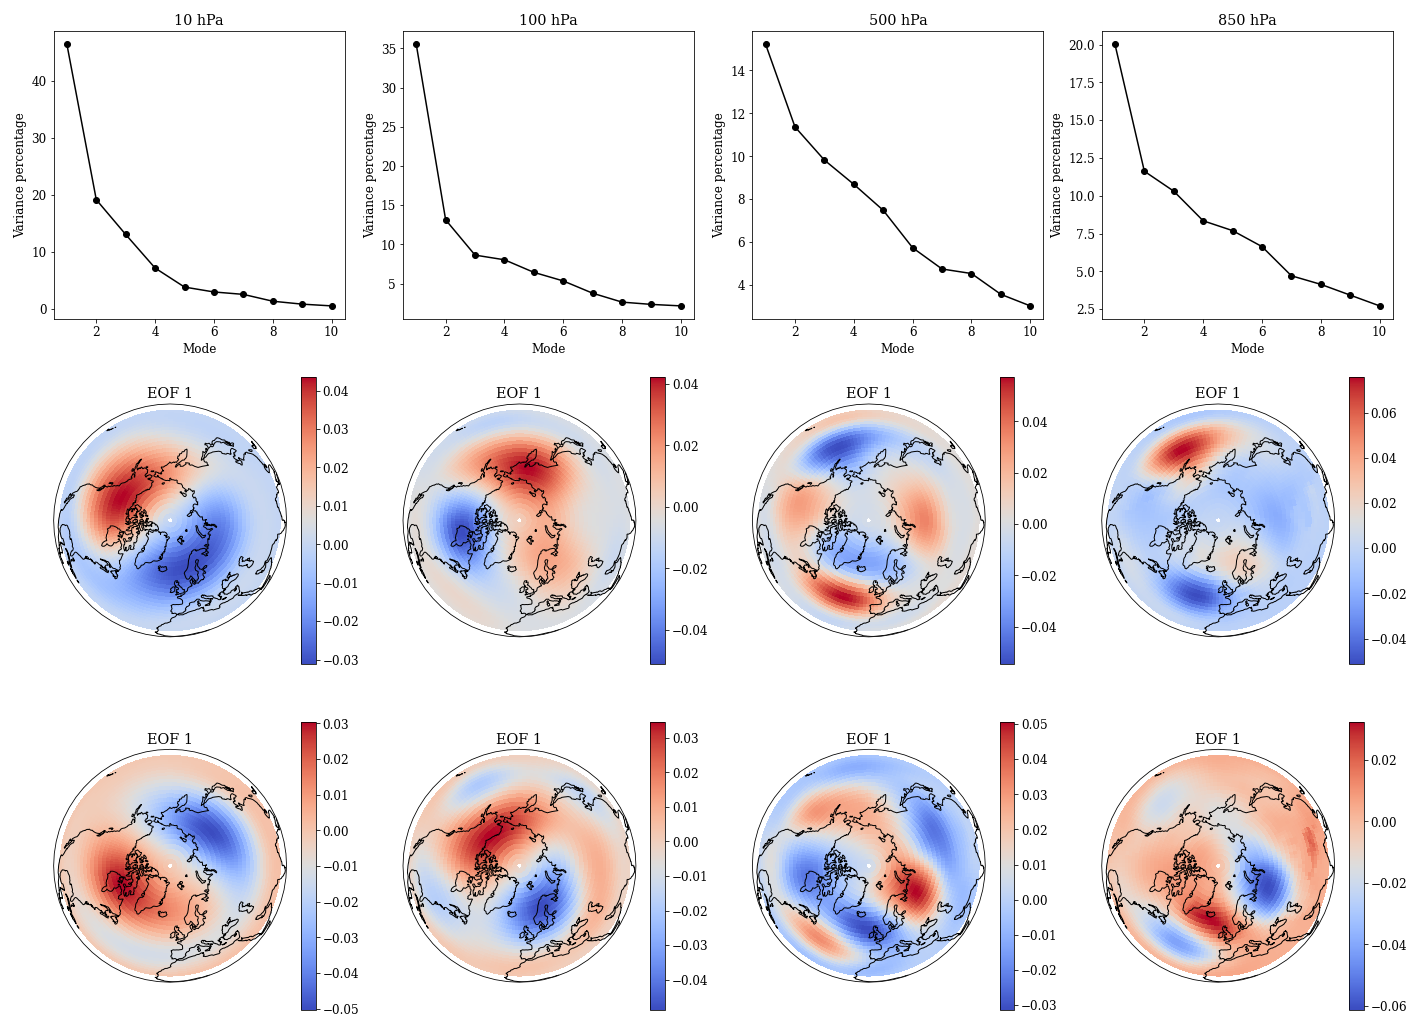

In [192]:
fig = plt.figure(figsize=(24,18))
for i_lev in range(4):
    # Plot singular value spectrum
    ax = fig.add_subplot(3,4,i_lev+1)
    vf = variance_fraction.isel(level=i_lev)
    ax.plot(variance_fraction.mode, 100*variance_fraction.isel(level=i_lev), marker='o', color='black')
    ax.set_xlabel("Mode")
    ax.set_ylabel("Variance percentage")
    ax.set_title(f"{singvals.level.data[i_lev]} hPa")
    # Plot EOF 1
    ax = fig.add_subplot(3,4,4+i_lev+1,projection=ccrs.Orthographic(-10,90))
    display_pole_field(eofs.isel(mode=1,level=i_lev), lat=eofs["latitude"], lon=eofs["longitude"], fig=fig, ax=ax)
    ax.set_title("EOF 1")
    # Plot EOF 2
    ax = fig.add_subplot(3,4,8+i_lev+1,projection=ccrs.Orthographic(-10,90))
    display_pole_field(eofs.isel(mode=2,level=i_lev), lat=eofs["latitude"], lon=eofs["longitude"], fig=fig, ax=ax)
    ax.set_title("EOF 1")
    

Save the EOF data to file where we can use it for features.

## Read database and compute features. 

In [227]:
reload(feature_stratosphere)

<module 'feature_stratosphere' from '/home/jf4241/ecmwf/tpt_ecmwf/examples/ssw/feature_stratosphere.py'>

In [228]:
feat_strat = feature_stratosphere.WinterStratosphereFeatures()
feat_strat.set_event_seasonal_params()
feat_strat.set_ab_code()

In [229]:
ds = xr.open_dataset(join(filedict["data"][src]["traj"]["dir"], filename))

In [230]:
pc = feat_strat.pc_observable(ds, ds_eofs, ds_monclim)

In [233]:
plt.plot(pc.sel(pc_f=""))

<xarray.DataArray ()>
array(223394.98497787)

In [213]:
if featurize_flag:
    feat_all = dict()
    for src in ["ra"]:
        ds_feature_list = []
        file_list = [f for f in os.listdir(filedict["data"][src]["traj"]["dir"]) if f.endswith(".nc")]
        for i_filename,filename in enumerate(file_list):
            ds = xr.open_dataset(join(filedict["data"][src]["traj"]["dir"], filename))
            if i_filename % 120 == 0:
                print(f"Starting file number {i_filename} out of {len(file_list)}")
            ds_feature_list += [
                xr.Dataset(
                    data_vars = dict({
                        # WARNING! So that this steps work, the 'feature' coordinate of each observable must be uniquely named. 
                        # For example, if the identity observable and energy observable both have a coordinate called "feature", 
                        # then xarray will assume it's the same and smush them together, filling in NaNs. This restricts what 
                        # we can use as feature names. 
                        "time_feature": feat_strat.time_observable(ds),
                        "ubar_feature": feat_strat.ubar_observable(ds),
                        "pc_feature": feat_strat.pc_observable(ds, eofs, zm_climatology)
                    })
                )
            ]
            ds.close()
        # Combine all the Datasets into a single one, concatenating either by time (if reanalysis) or ensemble (if S2S)
        concat_dim = "time" if src == "ra" else "ensemble"
        feat_all[src] = xr.concat(ds_feature_list,dim=concat_dim) # ensemble is a new dimension
        feat_all[src].to_netcdf(join(filedict["data"][src]["feat_all"]["dir"], filedict["data"][src]["feat_all"]["filename"]))

Starting file number 0 out of 732
Starting file number 120 out of 732
Starting file number 240 out of 732
Starting file number 360 out of 732
Starting file number 480 out of 732
Starting file number 600 out of 732
Starting file number 720 out of 732


In [218]:
feat_all["ra"]["pc_feature"].shape

(89120, 16)

In [14]:
feat_all = dict()
for src in ["ra"]:
    feat_all[src] = xr.open_dataset(
        join(
            filedict["data"][src]["feat_all"]["dir"], 
            filedict["data"][src]["feat_all"]["filename"]
        )
    ).sortby("time")

In [20]:
!ls -ltrh {join(filedict["data"][src]["feat_all"]["dir"], filedict["data"][src]["feat_all"]["filename"])}

-rw-r--r--. 1 jf4241 root 6.9M Aug 17 08:40 /scratch/jf4241/ecmwf_data/era5_data/features_all/2022-08-15/era5_features_all.nc


In [40]:
mean_jan = da_z.where(da_z["time"].dt.month==1, drop=True).mean(dim=["time"])
mean_feb = da_z.where(da_z["time"].dt.month==2, drop=True).mean(dim=["time"])

In [50]:
mean_dec.shape

(73, 144)

In [274]:
# Test of subtracting average

R = 1000*np.random.randn(100,3)
Ranom = R - np.mean(R, axis=0)
print(Ranom.mean(axis=0).min())

-1.3642420526593923e-14
